In [32]:
import os
import sys
from glob import glob
import numpy as np
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from __future__ import unicode_literals
from IPython.core.display import display, HTML
from pprint import pprint 
import traceback

import radical.utils     as ru
import warnings
import itertools
import matplotlib

warnings.filterwarnings('ignore')
pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)
matplotlib.use("Agg")

In [33]:
# Global configurations
# ---------------------

# Expand the notebook to the width of the browser
display(HTML("<style>.container { width:100% !important; }</style>"))

# Matplotlib style
plt.style.use('seaborn-colorblind')

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = False
mpl.rcParams['text.latex.unicode'] = False
mpl.rcParams['font.family'] = 'Average'
# mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 24
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 1
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['lines.linewidth'] = 2


# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Restore part of matplotlib 1.5 behavior
mpl.rcParams['patch.force_edgecolor'] = True
mpl.rcParams['errorbar.capsize'] = 3

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup(num_x, num_y, (size_x, size_y), (space_x, space_y)=(0.25,0.25)):
    fig, axes = plt.subplots(num_x, num_y, figsize=(size_x, size_y), gridspec_kw={'wspace':space_x, 'hspace':space_y}, sharex=False, sharey=False)
    if num_x == 1 and num_y == 1:
        axes = [[axes]]
#         for ax1 in axes:
#             for ax2 in ax1:
#                 ax2.get_xaxis().tick_bottom()  
#                 ax2.get_yaxis().tick_left()
    elif (num_x == 1 and num_y>1) or (num_x>1 and num_y == 1):
        axes = [axes]
#         for ax1 in axes:
#             for ax2 in ax1:
#                 ax2.get_xaxis().tick_bottom()  
#                 ax2.get_yaxis().tick_left()
    return fig, axes

In [34]:
cases = 4
trials = 30
fontsize=18
def parse_uids(uid):
    new_uid = int(uid.split('.')[-1])
    return new_uid

In [35]:
def extract(loc):
    df_dict = dict()
    for x in glob('%s/profile.*'%loc):
        print(x)
        json_data = ru.read_json(x)

    keys = sorted(json_data.keys())
    trials=30
    cur_trial = 1
    exp = 0
    hets = list()

    for key in keys:
        if exp==0:
            het = 0
        else:
            het = pow(2,exp)

        if het not in hets:
            hets.append(het)
            df_dict[het] = dict()

        prof = json_data[key]
        df = pd.DataFrame.from_dict(prof)
        df['core'] = df['core'].apply(parse_uids)
        df['task'] = df['task'].apply(parse_uids)
        df['perf'] = df['ops']/df['exec_time']

        df_dict[het][cur_trial] = df
        cur_trial +=1
        if cur_trial > trials:
            cur_trial = 1
            exp+=1

    return df_dict

In [36]:
def transform_late(dfs):
    hets = sorted(dfs.keys())
    df = pd.DataFrame(columns=['het','ttx'])
    df_err = pd.DataFrame(columns=['het','ttx'])
    result = dict()
    for het in hets:
        ttx = list()
        for t in range(1, trials+1):
            end_time_list = np.unique(dfs[het][t]['end_time'])
            if len(end_time_list) == 1:
                ttx.append(end_time_list[0] * 8)
            else:
                ttx.append(np.sum(end_time_list))
        result[het] = (np.mean(ttx), np.std(ttx))
        
    return result

In [37]:
def transform_early(dfs):
    hets = sorted(dfs.keys())
    df = pd.DataFrame(columns=['het','ttx'])
    df_err = pd.DataFrame(columns=['het','ttx'])
    result = dict()
    for het in hets:
        ttx = list()
        for t in range(1, trials+1):
            ttx.append(dfs[het][t]['end_time'].max() - dfs[het][t]['start_time'].min())
        result[het] = (np.mean(ttx), np.std(ttx))
        
    return result

In [ ]:
df = pd.DataFrame(columns=['case-%s'%x for x in range(1,5)], index=[0,2,4,8])
df_err = pd.DataFrame(columns=['case-%s'%x for x in range(1,5)], index=[0,2,4,8])

for case in range(1, 5):
    tmp = extract('case-1-%s'%case)
    if case==1 or case==3:
        res = transform_early(tmp)
    else:
        res = transform_late(tmp)
    avgs = [res[0][0], res[2][0], res[4][0], res[8][0]]
    stds = [res[0][1], res[2][1], res[4][1], res[8][1]]
    df['case-%s'%case] = avgs
    df_err['case-%s'%case] = stds
    
#df = pd.DataFrame(columns=['case-%s'%x for x in range(1,3)], index=[0,2,4,8])
#df_err = pd.DataFrame(columns=['case-%s'%x for x in range(1,3)], index=[0,2,4,8])

#for case in range(1, 3):
    
#    if case==1:
#        tmp = extract('case-1-1')
#    else:
#        tmp = extract('case-1-3')
            
#    res = transform_early(tmp)

#    avgs = [res[0][0], res[2][0], res[4][0], res[8][0]]
#    stds = [res[0][1], res[2][1], res[4][1], res[8][1]]
#    df['case-%s'%case] = avgs
#    df_err['case-%s'%case] = stds

case-1-1/profile.executor.2020.04.13.06.44.39.1587632.0000.json


In [28]:
print df
print df_err

       case-1      case-2
0  256.000000  256.000000
2  257.606677  256.007518
4  261.216589  255.590515
8  257.687696  261.206265
      case-1     case-2
0   0.000000   0.000000
2   9.248106   7.428274
4  18.594958  19.291494
8  35.354102  33.863012


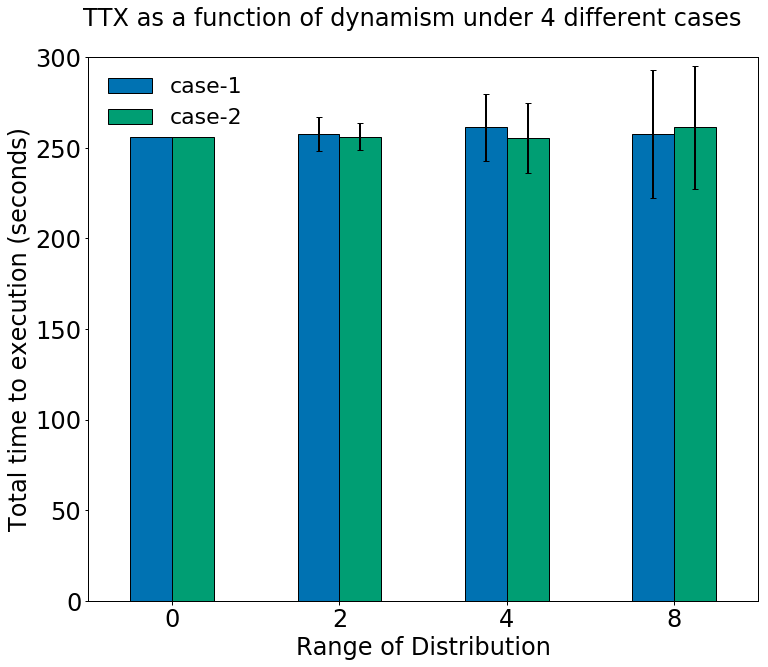

In [31]:
fig, axes = fig_setup(1,1,(12,10), (0.35,0.35))
title = 'Fluctuation in TTX as a function of heterogeinity, \n dynamism under 4 different cases'
fig.suptitle(title, y=0.95)

ax = df.plot(ax=axes[0][0], kind='bar', yerr=df_err)
# ax.set_xscale('log',basex=2)
ax.set_xticklabels([0,2,4,8], rotation=0)
# ax.set_xticks([0,6.25,12.5,25])
ax.set_xlabel('Range of Distribution')
ax.set_ylabel('Total time to execution (seconds)')
#ax.set_yscale('log')
ax.set_ylim(0,300)
ax.legend(loc='upper left',  ncol=1, bbox_to_anchor=(1.05, 1), borderaxespad=0.)
fname = 'ttx_4_cases.png'
#fig.savefig('plots/%s'%fname)